# Tutorial 6.4 - Orientation Selectivity in a Ring Model
### Neuroscience goal:
- see how contrast-invariant gain can arise from different network configurations
### Computational goal:
- simulate a large number of coupled ODEs, using arrays to store variables and their coupling constants

### Overview
- will simulate a network of 100 firing-rate model units (50 excitatory, 50 inhibitory)
    - to investigate how connections within the network shape neural responses to external input
- will compare feedforward model with recurrent circuit model

set up two arrays, with `Nt` rows and 50 columns, where `Nt` is number of time points to be simulated
- one array for excitatory cells and the other for inhibitory cells
- simulation of 300ms with 0.1ms is sufficient

In [4]:
import numpy as np
import matplotlib.pyplot as plt

define three 50x50 connectivity matrices, each of which can be initialized with entries of zero
- these are $W^{EE}, W^{EI}, W^{IE}$ (we ignore I-I connections in this tutorial)

their firing rates will be treated as a linear function of inputs, dynamics following:

$\tau _E \frac{dr_i^E}{dt} = -r_i^E + \frac{1}{N} \sum _j W_{ij}^{EE}r_j^E + \frac{1}{N}\sum _j W_{ij}^{IE}r_j^I + I_0^E + S_i^E $

$ \tau_ I \frac{dr_i^I}{dt} = -r_i^I + \frac{1}{N}\sum _j W_{ij}^{EI}r_j^E + I_0^I + S_i^I $

with additional conditions:

$r_i^E > 0$ and $r_i^I > 0$ for all units and all times 
    
in the preceeding equtions, $I_0^E$ and $I_0^I$ represnet baseline input to excitatory and inihibitory units, respectively
- a negative value for these quantities is equivalent to a positive threshold on the f-I curve

the stimulus-dependent inputs, $S_i^E$ and $S_i^I$, depend on the orientation preference of the unit labeled $i$
- we define the orientation preference of each excitatory unit as: $\theta_i = \pi i / N$, where N=50 is the total number of units of a given type
- we define the orientatio of the stimulus using $\theta_{cue} = \pi / 2$ 

- given these definitions, we use: 

    $ S_i^E = A_Ec[1 + \epsilon * \cos(2\theta_{cue} - 2\theta_i)]  $

    $ S_i^I = A_Ic[1 + \epsilon * \cos(2\theta_{cue} - 2\theta_i)]  $

    - with $c$ being the contrast, which will vary from 0 to 1
    - $\epsilon = 0.5$ represents the degree of modulation of input with orientation
    - in this case producing a threefold increase in input from the null direction
    (where $\theta_{cue} = \theta_i \pi / 2$, so $\cos(2\theta_{cue} - 2\theta_i) = -1$) to the preferred direction (where $\theta_{cue} = \theta_i$, so $\cos(2\theta_{cue} - 2\theta_i) = +1$)

other parameters depend on the network being simulated as follows:
- network A:
    - $\tau_E = \tau_I = $ 10ms
    - $I_0^E = I_0^I = -10$
    - $A_E = 40$
    - $A_i^I = 40$
    - $W_{ij}^{EE} = W_{ij}^{EI} = W_{ij}^{IE} = 0$

- network B:
    - $\tau_E = \tau_I = $ 10ms
    - $I_0^E = I_0^I = -5$
    - $A_E = 40$
    - $A_i^I = 40$
    - $W_{ij}^{EE} = W_{ij}^{EI} = 0$
    - $W_{ij}^{IE} = -[1+\cos(\pi + 2\theta_i - 2\theta_j)] / N$

- network C:
    - $\tau_E = $ 50ms
    - $\tau_I = $ 5ms
    - $I_0^E = 2$
    - $I_0^I = 0.5$
    - $A_E = 100$
    - $A_i^I = 0$
    - $W_{ij}^{EE} = 5[1 +\cos(2\theta_i - 2\theta_j)] / N$
    - $W_{ij}^{EI} = 3[1 + \cos(2\theta_i - 2\theta_j)] / N$
    - $W_{ij}^{IE} = -4[1+\cos(\pi + 2\theta_i - 2\theta_j)] / N$

#### Complete questions 1-4 using all (A, B, C) networks
### 1. simulate network as function of time, with stimulus present
- with all firing rates initially set at zero, simulate the network as a function of time, with the stimulus present the entire time
- use contrasts of 0, 0.25, 0.50, 0.75, 1

- *note*: firing rates can be stored as arrays, with each row representing a different time point and each column a different cell
- allows to sum over all excitatory units providing input nto all excitatory cells within the network to be calculated using matrix multiplication
    - e.g., `rE[i-1, :] * W_EE`

- each entry in the row vector produced by the preceding segment of code represents the total within-network excitatory input to a unit
- the `i-1` represents the previous time point, because firing rates at the previous time point are used when calculating input at the current time point, i

In [16]:
# parameter dictionary
n = 50
network_params = {
    'A': {
        'tau_e': 10,
        'tau_i': 10,
        'i_0_e': -10,
        'i_0_i': -10,
        'a_e': 40,
        'a_i_i': 40,
        'w_ee': 0,
        'w_ei': 0,
        'w_ie': 0
    },
    'B': {
        'tau_e': 10,
        'tau_i': 10,
        'i_0_e': -5,
        'i_0_i': -5,
        'a_e': 40,
        'a_i_i': 40,
        'w_ee': 0,
        'w_ei': 0,
        'w_ie': lambda theta_i, theta_j: - (1 + np.cos(np.pi + 2 * theta_i - 2 * theta_j)) / n

    },
    'C': {
        'tau_e': 50,
        'tau_i': 5,
        'i_0_e': 2,
        'i_0_i': 0.5,
        'a_e': 100,
        'a_i_i': 0,
        'w_ee': lambda theta_i, theta_j: 5 * (1 + np.cos(2 * theta_i - 2 * theta_j)) / n,
        'w_ei': lambda theta_i, theta_j: 3 * (1 + np.cos(2 * theta_i - 2 * theta_j)) / n,
        'w_ie': lambda theta_i, theta_j: -4 * (1 + np.cos(2 * theta_i - 2 * theta_j)) / n

    }
}

In [24]:
# initialize contrasts
contrasts = np.arange(0, 1.2, 0.25)

# set up time
dt = 0.1e-3
t = np.arange(0, 0.3, dt)

# initialize exc/inh arrays
exc = np.zeros((len(t), 50))
inh = np.zeros((len(t), 50))

# initialize connectivity matrices
# w_ee = np.zeros((50, 50))
# w_ei = np.zeros((50, 50))
# w_ie = np.zeros((50, 50))

# stimulus orientation
theta_cue = np.pi / 2
theta = np.pi * np.arange(50) / 50
epsilon = 0.5

# stimulus dependent inputs
def s_e(theta_i, contrast, network: str):
    """
    network must be in ['A', 'B', 'C']
    """
    if network not in ['A', 'B', 'C']:
        raise ValueError(f'network must be in ["A", "B", "C"]')
    return network_params[network]['a_e'] * contrast * (1 + epsilon * np.cos(2 * theta_cue - 2 * theta_i))

def s_i(theta_i, contrast, network: str):
    """
    network must be in ['A', 'B', 'C']
    """
    if network not in ['A', 'B', 'C']:
        raise ValueError(f'network must be in ["A", "B", "C"]')
    return network_params[network]['a_i_i'] * contrast * (1 + epsilon * np.cos(2 * theta_cue - 2 * theta_i))

# get weights
def compute_connectivity(network: str):

    w_ee = np.zeros((50, 50))
    w_ei = np.zeros((50, 50))
    w_ie = np.zeros((50, 50))

    for i in range(50):
        for j in range(50):
            if callable(network_params[network]['w_ee']):
                w_ee[i, j] = network_params[network]['w_ee'](theta[i], theta[j])
            else:
                w_ee[i, j] = network_params[network]['w_ee']

            if callable(network_params[network]['w_ei']):
                w_ei[i, j] = network_params[network]['w_ei'](theta[i], theta[j])
            else:
                w_ei[i, j] = network_params[network]['w_ei']
            
            if callable(network_params[network]['w_ie']):
                w_ie[i, j] = network_params[network]['w_ie'](theta[i], theta[j])
            else:
                w_ie[i, j] = network_params[network]['w_ie']

    return w_ee, w_ei, w_ie

In [20]:
def simulate_network(network: str, contrast: float, t: np.array, theta: np.array, dt: float, network_params: dict) -> (np.array, np.array):
    # get weight matrices
    w_ee, w_ei, w_ie = compute_connectivity(network)
    
    # initialize exc/inh arrays
    exc = np.zeros((len(t), 50))
    inh = np.zeros((len(t), 50))
    
    for i in range(1, len(t)):
        # total inputs to each neuron at this time step
        i_e = (1/50) * (exc[i-1, :] @ w_ee + inh[i-1, :] @ w_ie) + network_params[network]['i_0_e'] + s_e(theta, contrast, network)
        i_i = (1/50) * exc[i-1, :] @ w_ei + network_params[network]['i_0_i'] + s_i(theta, contrast, network)

        # update firing rates
        dre_dt = (-exc[i-1, :] + i_e) / network_params[network]['tau_e']
        dri_dt = (-inh[i-1, :] + i_i) / network_params[network]['tau_i']
        exc[i, :] = exc[i-1, :] + dre_dt * dt
        inh[i, :] = inh[i-1, :] + dri_dt * dt

        # firing rates cannot be negative
        exc[i, :] = np.maximum(0, exc[i, :])
        inh[i, :] = np.maximum(0, inh[i, :])

    return exc, inh


In [21]:
def simulate_all(t, theta, dt, network_params, contrasts):
    results = {}

    for network in ['A', 'B', 'C']:
        results[network] = {}
        for contrast in contrasts:
            exc, inh = simulate_network(network, contrast, t, theta, dt, network_params)
            results[network][contrast] = {'exc': exc, 'inh': inh}
    return results

### 2. plot
- use separate figures for excitatory/inhibitory units
- plot firing rate as a function of time for those units with preferred orientations of $\theta_i = \theta_{cue} = \pi / 2$ and $\theta_i = \pi$
- ensure the same figures are used for all five contrasts 

In [25]:
# units with preferred orientations
idx_pi_over_2 = np.argmin(np.abs(theta - np.pi/2))
idx_pi = np.argmin(np.abs(theta - np.pi))

results = simulate_all(t, theta, dt, network_params, contrasts)

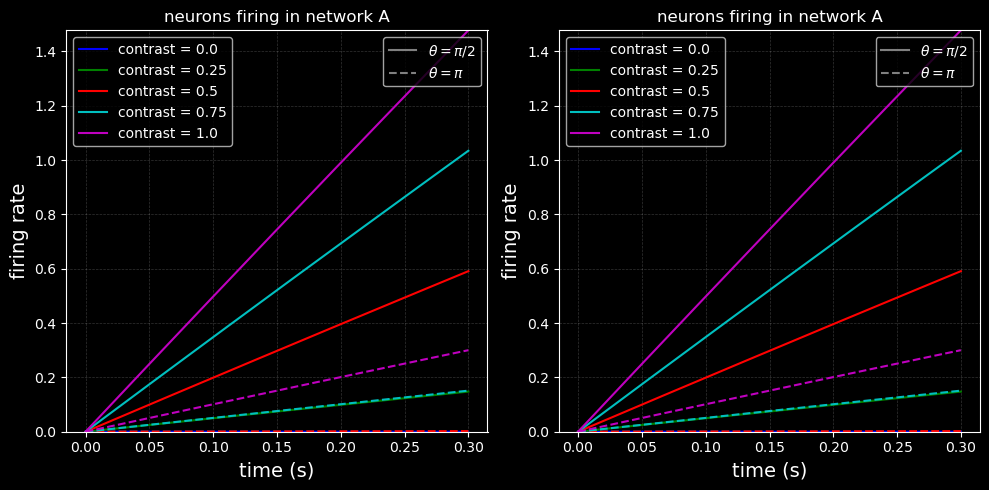

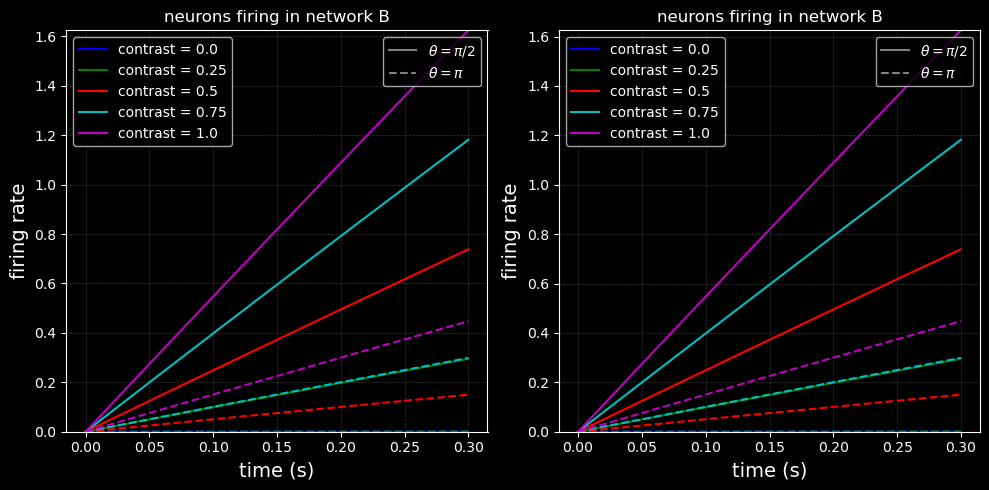

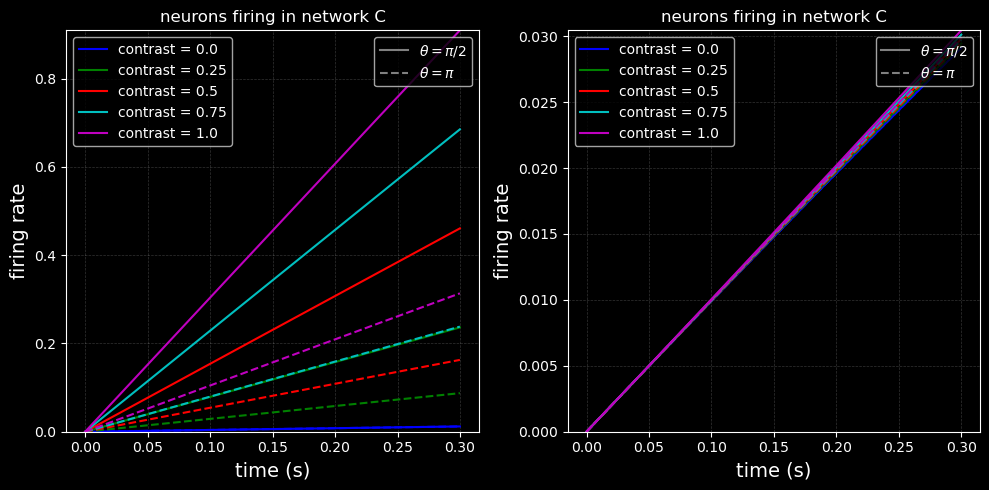

In [59]:
colors = ['b', 'g', 'r', 'c', 'm']
linestyles = ['-', '--']
linewidth = 1.5

for network in ['A', 'B', 'C']:
    contrast_results = results[network]
    
    # Determine global y-limits for each network's plots
    all_exc_values = np.concatenate([contrast_results[c]['exc'] for c in contrast_results])
    all_inh_values = np.concatenate([contrast_results[c]['inh'] for c in contrast_results])
    
    ylim_exc = (0, all_exc_values.max())
    ylim_inh = (0, all_inh_values.max())
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    for idx, c in enumerate(contrast_results):
        exc = contrast_results[c]['exc']
        inh = contrast_results[c]['inh']
        
        color = colors[idx]

        # Plot for excitatory neurons
        ax[0].plot(t, exc[:, idx_pi_over_2], label=f'contrast = {c}', color=color, linestyle=linestyles[0], linewidth=linewidth)
        ax[0].plot(t, exc[:, idx_pi], color=color, linestyle=linestyles[1], linewidth=linewidth)
        ax[0].set_ylim(ylim_exc)  # set y-limits

        # Plot for inhibitory neurons
        ax[1].plot(t, inh[:, idx_pi_over_2], label=f'contrast = {c}', color=color, linestyle=linestyles[0], linewidth=linewidth)
        ax[1].plot(t, inh[:, idx_pi], color=color, linestyle=linestyles[1], linewidth=linewidth)
        ax[1].set_ylim(ylim_inh)  # set y-limits

    # Creating legends
    for a in ax:
        a.set_xlabel('time (s)', fontsize=14)
        a.set_ylabel('firing rate', fontsize=14)
        
        # Legend for contrasts
        handles, labels = a.get_legend_handles_labels()
        legend1 = a.legend(handles[:5], labels[:5], title="", loc="upper left", fontsize=10)
        
        # Legend for theta values
        line1, = a.plot([], [], color='grey', linestyle=linestyles[0], label='$\\theta = \pi /2$')
        line2, = a.plot([], [], color='grey', linestyle=linestyles[1], label='$\\theta = \pi$')
        legend2 = a.legend(handles=[line1, line2], loc="upper right", fontsize=10)
        a.add_artist(legend1)
        
        a.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.2)
        a.set_title(f'neurons firing in network {network}')

    plt.tight_layout()
